# Imports

This section imports all necessary libraries and modules, including PyTorch, NumPy, and a local module bayesipy, which appears to handle Bayesian inference methods. Ensure all dependencies are installed.

In [1]:
# Imports and setup for automatic reloading of modules
%load_ext autoreload
%autoreload 2

# Importing necessary libraries
import numpy as np
import torch
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from torch import optim
import copy
import hamiltorch
from hamiltorch import util

# Adjusting system path for local imports
sys.path.append("..")
sys.path.append(".")

# Importing custom modules from bayesipy
from bayesipy.utils.datasets import Synthetic_Dataset
from bayesipy.fmgp import FMGP
from bayesipy.laplace import Laplace, ELLA, VaLLA
from bayesipy.mfvi import MFVI
from bayesipy.utils import gaussian_logdensity

c:\Users\Ludvins\Documents\VariationalUncertaintyEstimation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Experimental settings

To ensure reproducibility, a random seed is set. Then, a synthetic dataset is loaded and split into training and test sets, and data loaders are created to handle batched data processing.

In [2]:
# Setting reproducibility
from bayesipy.utils import assert_reproducibility

# Set seed to ensure consistent results across runs
assert_reproducibility(1234)

Load Dataset and desired split.

In [3]:
# Load synthetic dataset and split into train/test sets
dataset = Synthetic_Dataset()
train_dataset, test_dataset = dataset.get_splits()

Number of samples:  400
Input dimension:  (1,)
Label dimension:  1


Create Data loaders for training and test partitions.

In [4]:
# Define batch size and create DataLoaders for efficient data handling
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Pretrained MAP solution

In this section, a neural network is initialized and trained as a Maximum a Posteriori (MAP) solution. The network has two hidden layers with Tanh activations and is optimized using the Adam optimizer. After training, the best noise variance is selected by maximizing the log-likelihood on the training data.

In [5]:
# Initialize neural network for MAP solution with two hidden layers
f = torch.nn.Sequential(
    torch.nn.Linear(1, 50),
    torch.nn.Tanh(),
    torch.nn.Linear(50, 50),
    torch.nn.Tanh(),
    torch.nn.Linear(50, 1),
).to(torch.float64)  # Use double precision

# Set up optimizer and loss function
opt = torch.optim.Adam(f.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training loop for MAP optimization
start = timer()
iterator = iter(train_loader)
for _ in range(12000):
    try:
        X, y = next(iterator)  # Get batch data
    except StopIteration:
        iterator = iter(train_loader)
        X, y = next(iterator)

    opt.zero_grad()  # Clear gradients
    y_pred = f(X)  # Forward pass
    loss = criterion(y_pred, y)  # Calculate loss
    loss.backward()  # Backward pass
    opt.step()  # Update parameters
end = timer()

Create a copy of the pre-trained model for HamilTorch initialization

In [6]:
# Deep copy initial parameters for HMC sampling
params_init = copy.deepcopy(hamiltorch.util.flatten(f).detach())




This cell calculates the best noise variance by iterating over a range of noise values and computing the log-likelihood for each. The noise value that maximizes the log-likelihood is selected as the best noise variance.


In [7]:
# Find best noise variance by maximizing log-likelihood on training data
noises = np.linspace(0.001, 0.2, 100)
best_noise = 0
best_ll = -np.inf
mean = f(torch.tensor(train_dataset.inputs)).detach().cpu().numpy().flatten()
for noise in noises:
    # Gaussian density calculation
    ll = (
        -0.5 * np.log(2 * np.pi * noise)
        - 0.5 * np.square(train_dataset.targets.flatten() - mean) / noise
    ).sum()
    if ll > best_ll:
        best_ll = ll
        best_noise = noise

print("Best noise variance:", best_noise)
print("Best log-likelihood:", best_ll)

Best noise variance: 0.00301010101010101
Best log-likelihood: 545.231212359985


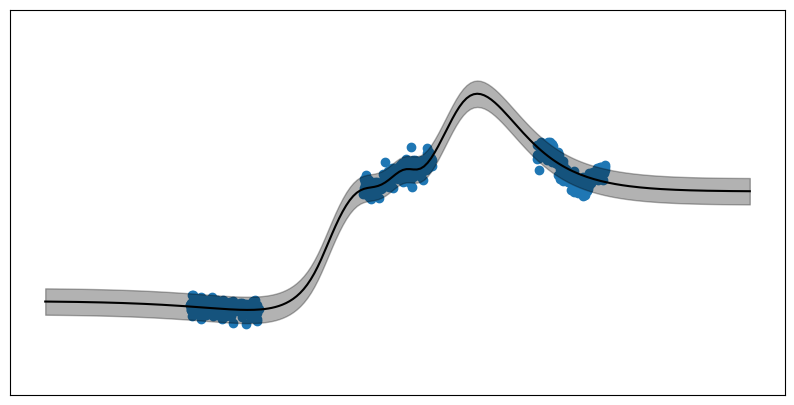

In [8]:
# Plot predictions with MAP uncertainty bounds
plt.figure(figsize=(10, 5))
plt.scatter(train_dataset.inputs, train_dataset.targets, label="Training points")
sort = np.argsort(test_dataset.inputs.flatten())

# Calculate predictions for test data
mean = f(torch.tensor(test_dataset.inputs)).detach().cpu().numpy().flatten()[sort]
plt.plot(test_dataset.inputs.flatten()[sort], mean, label="Predictions", color="black")
plt.fill_between(
    test_dataset.inputs.flatten()[sort],
    mean - 2 * np.sqrt(best_noise),
    mean + 2 * np.sqrt(best_noise),
    alpha=0.3,
    color="black",
)
plt.ylim(-1.2, 2)
plt.xticks([])
plt.yticks([])
plt.savefig("synthetic_regression_map.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Gaussian Process

Here, a Gaussian Process (GP) with an RBF kernel is implemented from scratch. The GP model is trained by maximizing the log marginal likelihood, which optimizes hyperparameters like length scale, variance, and noise.

In [9]:
# Define RBF kernel class
class RBFKernel(torch.nn.Module):
    def __init__(self, length_scale=1.0, variance=1.0):
        super(RBFKernel, self).__init__()
        # Initialize kernel hyperparameters
        self.length_scale = torch.nn.Parameter(
            torch.tensor(length_scale, dtype=torch.float64)
        )
        self.variance = torch.nn.Parameter(torch.tensor(variance, dtype=torch.float64))

    def forward(self, X1, X2):
        # Compute squared Euclidean distance
        sqdist = ((X1.unsqueeze(1) - X2.unsqueeze(0)) ** 2).sum(2)
        # Return RBF kernel result
        return self.variance * torch.exp(-0.5 * sqdist / self.length_scale**2)


# Define Gaussian Process model class
class GaussianProcess(torch.nn.Module):
    def __init__(self, kernel, noise=1e-1):
        super(GaussianProcess, self).__init__()
        self.kernel = kernel
        self.noise = torch.nn.Parameter(torch.tensor(noise, dtype=torch.float64))

    def forward(self, X_train, y_train):
        # Compute kernel matrix with noise term
        K = self.kernel(X_train, X_train) + self.noise**2 * torch.eye(
            X_train.size(0), dtype=torch.float64
        )
        L = torch.linalg.cholesky(K)  # Cholesky decomposition
        alpha = torch.cholesky_solve(y_train, L)  # Solve for alpha
        return K, L, alpha

    def marginal_likelihood(self, X_train, y_train):
        K, L, alpha = self.forward(X_train, y_train)
        # Compute log marginal likelihood components
        data_fit = -0.5 * y_train.T @ alpha
        complexity_penalty = -torch.sum(torch.log(torch.diagonal(L)))
        normalization = -0.5 * X_train.size(0) * np.log(2 * torch.pi)
        return (data_fit + complexity_penalty + normalization).squeeze()

    def predict(self, X_train, y_train, X_test):
        # Compute kernels for prediction
        K_train = self.kernel(X_train, X_train) + self.noise**2 * torch.eye(
            X_train.size(0), dtype=torch.float64
        )
        K_train_test = self.kernel(X_train, X_test)
        K_test_test = self.kernel(X_test, X_test)
        L = torch.linalg.cholesky(K_train)
        alpha = torch.cholesky_solve(y_train, L)

        # Predictive mean and variance
        predictive_mean = K_train_test.T @ alpha
        v = torch.cholesky_solve(K_train_test, L)
        predictive_variance = K_test_test - K_train_test.T @ v
        return predictive_mean.squeeze().detach(), torch.diag(
            predictive_variance
        ).sqrt().detach() + self.noise.item()

In [10]:
# Instantiate the RBF kernel and Gaussian Process (GP) model
kernel = RBFKernel(length_scale=1.0, variance=1.0)
gp = GaussianProcess(kernel=kernel, noise=1e-1)

# Define optimizer for GP model parameters

optimizer = optim.Adam(gp.parameters(), lr=0.01)

# Training loop to optimize GP log marginal likelihood
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Reset gradients
    # Negative log marginal likelihood for training data
    nll = -gp.marginal_likelihood(
        torch.tensor(train_dataset.inputs), torch.tensor(train_dataset.targets)
    )
    nll.backward()  # Backpropagate loss
    optimizer.step()  # Update GP parameters

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Negative Log Marginal Likelihood = {nll.item()}")

# Print optimized GP hyperparameters
print(f"Optimized length_scale: {kernel.length_scale.item()}")
print(f"Optimized variance: {kernel.variance.item()}")
print(f"Optimized noise: {gp.noise.item()}")

Epoch 0: Negative Log Marginal Likelihood = -456.2971033954215
Epoch 10: Negative Log Marginal Likelihood = -574.74391134798
Epoch 20: Negative Log Marginal Likelihood = -575.7743086243393
Epoch 30: Negative Log Marginal Likelihood = -577.2815578425971
Epoch 40: Negative Log Marginal Likelihood = -577.3822041864476
Epoch 50: Negative Log Marginal Likelihood = -577.9768032203744
Epoch 60: Negative Log Marginal Likelihood = -578.758590406992
Epoch 70: Negative Log Marginal Likelihood = -579.1378203596666
Epoch 80: Negative Log Marginal Likelihood = -579.4150776165498
Epoch 90: Negative Log Marginal Likelihood = -579.4878538745731
Optimized length_scale: 1.080517380521987
Optimized variance: 0.25044569441512354
Optimized noise: 0.05088144283571142


This visualization cell shows GP predictions with confidence intervals, based on the optimized hyperparameters. It illustrates the GP’s capability to model uncertainty in predictions.

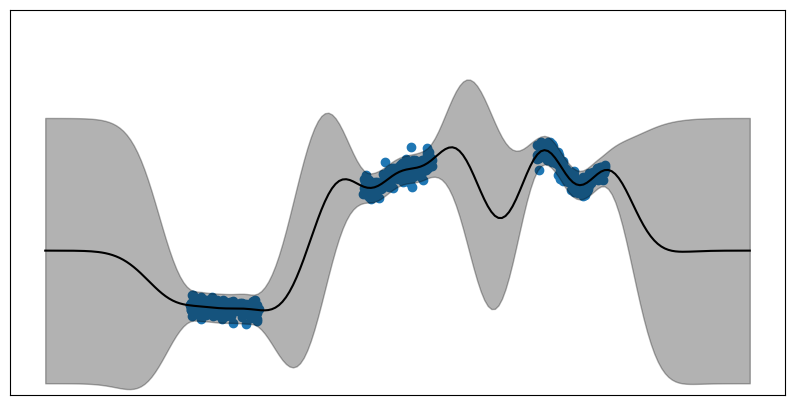

In [11]:
# Plot GP predictions with confidence intervals
plt.figure(figsize=(10, 5))
plt.scatter(train_dataset.inputs, train_dataset.targets, label="Training points")
sort = np.argsort(test_dataset.inputs.flatten())

# Generate predictions and uncertainties for GP model
mean, std = gp.predict(
    torch.tensor(train_dataset.inputs),
    torch.tensor(train_dataset.targets),
    torch.tensor(test_dataset.inputs),
)

plt.plot(
    test_dataset.inputs.flatten()[sort],
    mean,
    label="Predictions",
    color="black",
)
plt.fill_between(
    test_dataset.inputs.flatten()[sort],
    mean - 2 * std,
    mean + 2 * std,
    alpha=0.3,
    color="black",
)

plt.ylim(-1.2, 2)
plt.xticks([])
plt.yticks([])
plt.savefig("synthetic_regression_GP.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Mean Field Variational Inference (MFVI)

This section introduces MFVI as an alternative Bayesian inference method. The MFVI class approximates the posterior distribution over the model parameters. The model is trained for 50,000 iterations, generating samples for predictions.

In [12]:
# Initialize Mean Field Variational Inference (MFVI) model
mfvi = MFVI(
    copy.deepcopy(f),  # Copy of pretrained model
    n_samples=200,  # Number of samples for predictions
    likelihood="regression",
    noise_std=4,  # Assumed noise standard deviation
    prior_precision=1.0,  # Prior precision for regularization
    y_mean=0.0,  # Mean of target for standardization
    y_std=1.0,  # Standard deviation of target
    seed=0,
)

# Train MFVI model with 50,000 iterations
losses = mfvi.fit(train_loader, 50000, verbose=True)

# Generate predictions for MFVI model on test dataset
mfvi_preds = mfvi.sample(torch.tensor(test_dataset.inputs)).detach().cpu().numpy()

Training : 100%|██████████| 50000/50000 [02:14<00:00, 372.86 iteration/s]


This plot compares MFVI predictions to the training data, showing mean predictions and uncertainty intervals derived from the MFVI posterior samples.

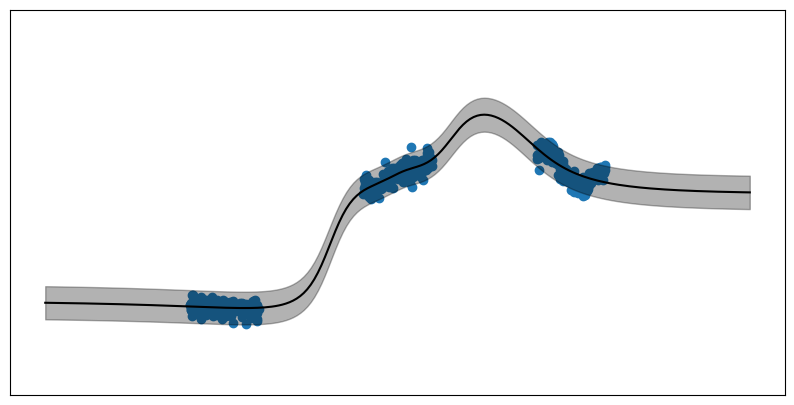

In [13]:
# Plot MFVI predictions with uncertainty intervals
plt.figure(figsize=(10, 5))
plt.scatter(train_dataset.inputs, train_dataset.targets, label="Training points")
sort = np.argsort(test_dataset.inputs.flatten())

# Compute mean and variance from MFVI posterior samples
mean = mfvi_preds.mean(axis=0).flatten()
variance = mfvi.log_noise.exp().item() ** 2 + mfvi_preds.var(axis=0)
std = np.sqrt(variance).flatten()

plt.plot(
    test_dataset.inputs.flatten()[sort],
    mean,
    label="Predictions",
    color="black",
)
plt.fill_between(
    test_dataset.inputs.flatten()[sort],
    mean - 2 * std,
    mean + 2 * std,
    alpha=0.3,
    color="black",
)

plt.ylim(-1.2, 2)
plt.xticks([])
plt.yticks([])
plt.savefig("synthetic_regression_MFVI.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Hamiltonian Monte Carlo (HMC) Sampling

In this section, HMC sampling is applied to obtain a Bayesian posterior distribution over the model’s parameters. The log-probability function considers Gaussian noise for likelihood and prior distributions on weights.

In [14]:
f_new = torch.nn.Sequential(
    torch.nn.Linear(1, 50),
    torch.nn.Tanh(),
    torch.nn.Linear(50, 50),
    torch.nn.Tanh(),
    torch.nn.Linear(50, 1),
).to(torch.float64)

In [15]:
# Create functional model for HMC sampling
fmodel = util.make_functional(f_new)


# Define function for log-probability in Hamiltonian Monte Carlo (HMC)
def model_log_prob(params):
    # Extract network parameters, noise standard deviation, and prior precision
    net_params = params[:-2]
    std_noise = torch.exp(params[-2])
    std_prior = torch.exp(params[-1])

    # Update network weights with current parameter values
    params_unflattened = util.unflatten(f_new, net_params)

    # Predict using model and calculate Gaussian log-density for likelihood
    y_pred = fmodel(
        torch.tensor(train_dataset.inputs), params=params_unflattened
    ).flatten()
    likelihood = gaussian_logdensity(
        y_pred, std_noise**2, torch.tensor(train_dataset.targets).flatten()
    ).sum()

    # Gaussian prior on network weights
    log_prior_w = gaussian_logdensity(
        net_params, std_prior**2, torch.zeros_like(net_params)
    ).sum()

    # Unnormalized priors for noise and prior variance
    log_prior_std_noise = -torch.log(std_noise)
    log_prior_std_prior = -torch.log(std_prior)

    # Return log-probability
    return likelihood + log_prior_w + log_prior_std_noise + log_prior_std_prior

In [16]:
# Set up HMC sampling with initial noise and prior variance parameters
v_noise_init = torch.tensor([np.log(0.06)], dtype=torch.float64)
v_prior_init = torch.tensor([0], dtype=torch.float64)

# Concatenate initial parameters for HMC
params_init_hmc = torch.cat([params_init, v_noise_init, v_prior_init])

# Initialize HMC parameters
inv_mass = torch.ones(params_init_hmc.shape) * 0.1
hamiltorch.set_random_seed(0)

# Run HMC sampling
params_hmc = hamiltorch.sample(
    log_prob_func=model_log_prob,
    params_init=params_init_hmc,
    num_samples=1000,
    burn=-1,
    inv_mass=inv_mass,
    step_size=0.0005,
    num_steps_per_sample=500,
    sampler=hamiltorch.Sampler.HMC,
)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:08:55 | 0d:00:00:00 | #################### | 1000/1000 | 1.87       
Acceptance Rate 0.97


In [17]:
# Generate predictions from HMC samples
y_preds = []
noise_stds = []

# Loop over sampled parameters to compute predictions and noise std deviations
for params in params_hmc:
    net_params = params[:-2]
    std_noise = torch.exp(params[-2])

    # Store noise standard deviation
    noise_stds.append(std_noise.item())

    # Unflatten network parameters and compute predictions
    params_unflattened = util.unflatten(f_new, net_params)
    y_pred = fmodel(
        torch.tensor(test_dataset.inputs), params=params_unflattened
    ).flatten()
    y_preds.append(y_pred.detach().numpy())

# Convert lists to arrays for easier manipulation
y_preds = np.array(y_preds).squeeze()
noise_stds = np.array(noise_stds).squeeze()
mean_preds = y_preds.mean(axis=0)

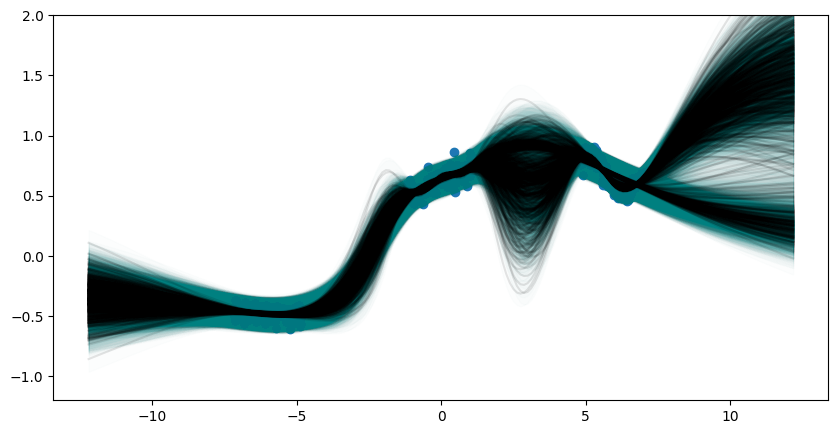

In [18]:
# Plot HMC predictions with uncertainty intervals
plt.figure(figsize=(10, 5))
plt.scatter(train_dataset.inputs, train_dataset.targets, label="Training points")
sort = np.argsort(test_dataset.inputs.flatten())

# Plot each sampled prediction with slight transparency
for mean, std in zip(y_preds, noise_stds):
    plt.plot(test_dataset.inputs.flatten()[sort], mean[sort], color="black", alpha=0.1)
    plt.fill_between(
        test_dataset.inputs.flatten()[sort],
        mean[sort] - 2 * std,
        mean[sort] + 2 * std,
        alpha=0.01,
        color="teal",
    )

plt.ylim(-1.2, 2)
plt.show()

In [19]:
# Compute variance of mixture for predictive uncertainty
mean = y_preds.mean(axis=0)[np.newaxis, :]
within_component_variance = noise_stds**2
between_component_variance = np.sum((y_preds - mean) ** 2, axis=0) / y_preds.shape[0]
var_mixture = between_component_variance + within_component_variance.mean()
std = np.sqrt(var_mixture).flatten()

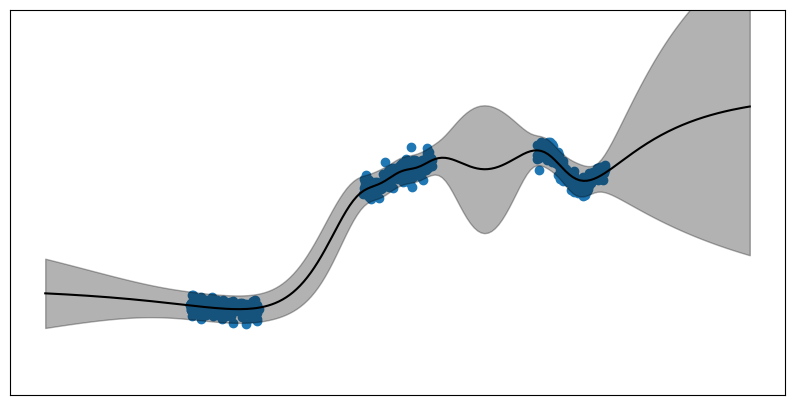

In [20]:
# Plot final predictive mean and uncertainty for HMC
plt.figure(figsize=(10, 5))
plt.scatter(train_dataset.inputs, train_dataset.targets, label="Training points")
sort = np.argsort(test_dataset.inputs.flatten())

plt.plot(
    test_dataset.inputs.flatten()[sort],
    mean.flatten(),
    label="Predictions",
    color="black",
)
plt.fill_between(
    test_dataset.inputs.flatten()[sort],
    mean.flatten() - 2 * std,
    mean.flatten() + 2 * std,
    alpha=0.3,
    color="black",
)

plt.ylim(-1.2, 2)
plt.xticks([])
plt.yticks([])
plt.savefig("synthetic_regression_HMC.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Fixed-Mean Gaussian Processes

In [21]:
fmgp = FMGP(
    model=copy.deepcopy(f),  # Copy of MAP-trained model
    likelihood="regression",  # Regression setting
    kernel="RBF",  # RBF kernel for GP
    inducing_locations="kmeans",  # Use k-means to select inducing points
    num_inducing=10,  # Number of inducing points
    noise_variance=np.exp(-5),  # Initial noise variance
    subrogate_regularizer=True,  # Use subrogate regularizer
    y_mean=0,  # Mean of target
    y_std=1,  # Standard deviation of target
)

# Train FMGP model with specified learning rate and iterations
loss = fmgp.fit(iterations=70000, lr=0.001, train_loader=train_loader, verbose=True)

Initializing inducing locations... done
Creating Kernel Function... done


Training : 100%|██████████| 70000/70000 [04:57<00:00, 235.12 iteration/s, loss=-1126.35, lr=0.001]


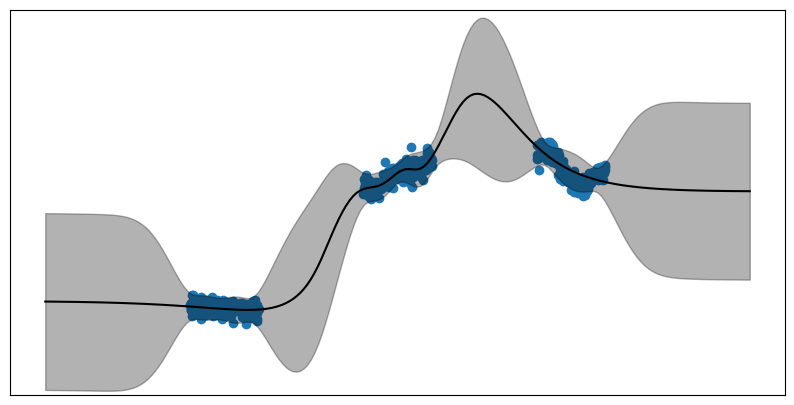

In [22]:
# Plot FMGP predictions with uncertainty bounds
plt.figure(figsize=(10, 5))
plt.scatter(train_dataset.inputs, train_dataset.targets, label="Training points")
sort = np.argsort(test_dataset.inputs.flatten())

# Generate FMGP predictions and variances for test inputs
f_mean, f_var = fmgp.predict(torch.tensor(test_dataset.inputs))

# Plot FMGP mean predictions with 95% confidence intervals
plt.plot(
    test_dataset.inputs.flatten()[sort],
    f_mean.detach().cpu().numpy().flatten()[sort],
    label="Predictions",
    color="black",
)
plt.fill_between(
    test_dataset.inputs.flatten()[sort],
    f_mean.detach().cpu().numpy().flatten()[sort]
    - 2 * np.sqrt(f_var.detach().cpu().numpy().flatten()[sort]),
    f_mean.detach().cpu().numpy().flatten()[sort]
    + 2 * np.sqrt(f_var.detach().cpu().numpy().flatten()[sort]),
    alpha=0.3,
    color="black",
)

plt.ylim(-1.2, 2)
plt.xticks([])
plt.yticks([])
plt.savefig("synthetic_regression_fmgp.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Laplace Approximation (LLA)

In this part, the Laplace approximation method is applied to approximate the posterior over the model parameters. This approach is computationally efficient and provides Gaussian approximations around a MAP solution.

In [23]:
# Initialize Laplace Approximation (LLA) model
lla = Laplace(
    model=copy.deepcopy(f),  # Copy of MAP-trained model
    likelihood="regression",  # Set for regression
    subset_of_weights="all",  # Use all weights for approximation
    hessian_structure="full",  # Full Hessian structure for Gaussian approximation
)

# Train LLA model to compute posterior scale
lla.fit(train_loader=train_loader)

# Define log prior and log noise for LLA hyperparameters
log_sigma = torch.zeros(1, requires_grad=True)
log_prior = torch.zeros(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

# Optimize LLA hyperparameters over 100 iterations
for i in range(100):
    hyper_optimizer.zero_grad()
    neg_marglik = -lla.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

# Print optimized prior precision and noise sigma
prior_precision = log_prior.exp().item()
sigma_noise = log_sigma.exp().item()
print("Prior precision:", prior_precision)
print("Sigma noise:", sigma_noise)

Prior precision: 0.199293851852417
Sigma noise: 0.06208699941635132


In [24]:
# Compute posterior scale for predictions and store as float64
lla._compute_scale()
lla._posterior_scale = lla._posterior_scale.to(torch.float64)

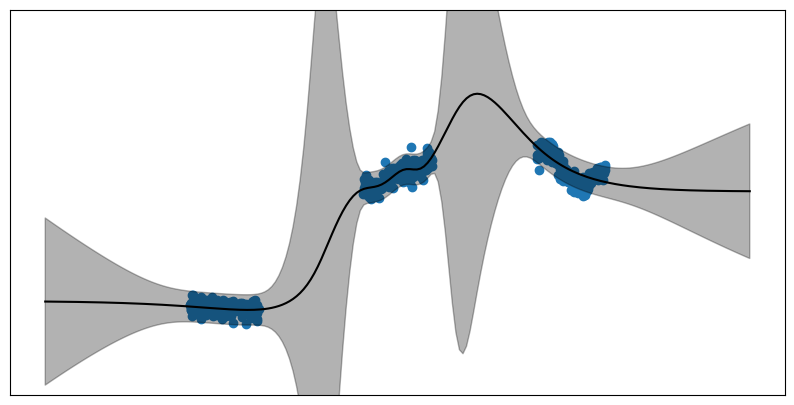

In [25]:
# Plot LLA predictions with uncertainty intervals
plt.figure(figsize=(10, 5))
plt.scatter(train_dataset.inputs, train_dataset.targets, label="Training points")
sort = np.argsort(test_dataset.inputs.flatten())

# Generate mean and variance predictions with LLA
f_mean, f_var = lla.predict(torch.tensor(test_dataset.inputs))

# Plot LLA mean predictions with confidence intervals
plt.plot(
    test_dataset.inputs.flatten()[sort],
    f_mean.detach().cpu().numpy().flatten()[sort],
    label="Predictions",
    color="black",
)
plt.fill_between(
    test_dataset.inputs.flatten()[sort],
    f_mean.detach().cpu().numpy().flatten()[sort]
    - 2 * np.sqrt(f_var.detach().cpu().numpy().flatten()[sort]),
    f_mean.detach().cpu().numpy().flatten()[sort]
    + 2 * np.sqrt(f_var.detach().cpu().numpy().flatten()[sort]),
    alpha=0.3,
    color="black",
)

plt.ylim(-1.2, 2)
plt.xticks([])
plt.yticks([])
plt.savefig("synthetic_regression_lla.pdf", format="pdf", bbox_inches="tight")
plt.show()